In [2]:
import glob
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import rocks
rocks.set_log_level("error")
import time as t

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import angular_separation

import seaborn as sns
sns.set_context('talk')

In [3]:
# Local Configuration
bft_file = '/home/bcarry/Downloads/ssoBFT-latest.parquet'
# data_fink = '/data/fink/tutorials/sso/spins/'
data_fink = './'

# To choose the definitSSHADE / PSuion of sets
# gold_silver_choice = 'julien'
gold_silver_choice = 'benoit'

In [4]:
# Simple BFT reading function & Column selection
def read_bft(path):
    cols = [
        'sso_number', 
        'orbital_elements.semi_major_axis.value', 
        'orbital_elements.eccentricity.value', 
        'orbital_elements.inclination.value', 
        'orbital_elements.node_longitude.value',
        'proper_elements.proper_semi_major_axis.value',
        'proper_elements.proper_eccentricity.value',
        'proper_elements.proper_inclination.value',
        'proper_elements.proper_sine_inclination.value',
        'family.family_number', 'family.family_name',
        'absolute_magnitude.value', 
        'diameter.value', 
        'mass.value', 
        'taxonomy.class', 
        'taxonomy.complex', 
        'phase_functions.Generic/Johnson.V.H.value',
        'phase_functions.Generic/Johnson.V.G1.value',
        'phase_functions.Generic/Johnson.V.G2.value',
        'sso_class'
    ]
    
    for ks in ['1','2','3','4']:
        cols.append(f'spins.{ks}.RA0.value')
        cols.append(f'spins.{ks}.DEC0.value')
        cols.append(f'spins.{ks}.long.value')
        cols.append(f'spins.{ks}.lat.value')
        cols.append(f'spins.{ks}.obliquity')
    
    bft = pd.read_parquet(path, columns=cols)
    
    return bft

In [5]:
# G12 line in G1G2 space
def G12_to_G1G2(g12):

    G1_a, G2_a = 0.0, 0.53513350
    G1_b, G2_b = 0.84293649, -0.53513350

    G1 = G1_a + g12 * G1_b
    G2 = G2_a + g12 * G2_b

    return G1, G2


In [6]:
# Read FINK results
raw = pd.read_parquet(f'{data_fink}data/sso_bft_50_inf_hg1g2spins.parquet')

names_numbers = rocks.identify(raw.ssnamenr)
raw['ssnamenr'] = [str(name_number[1]) for name_number in names_numbers]

print(len(raw))

# Merge with BFT
pdf_bft = read_bft(bft_file)
pdf_bft = pdf_bft.rename(columns={'sso_number': 'ssnamenr'})
mask = pdf_bft['ssnamenr'].apply(lambda x: x == x)
pdf_bft = pdf_bft[mask]
pdf_bft['ssnamenr'] = pdf_bft['ssnamenr'].apply(lambda x: str(int(x)))

data = raw.merge(pdf_bft, on='ssnamenr')
print(len(data))

104242
104005


In [7]:
data.columns

Index(['ssnamenr', 'nmeasurements', 'ndays', 'params',
       'orbital_elements.semi_major_axis.value',
       'orbital_elements.eccentricity.value',
       'orbital_elements.inclination.value',
       'orbital_elements.node_longitude.value',
       'proper_elements.proper_semi_major_axis.value',
       'proper_elements.proper_eccentricity.value',
       'proper_elements.proper_inclination.value',
       'proper_elements.proper_sine_inclination.value', 'family.family_number',
       'family.family_name', 'absolute_magnitude.value', 'diameter.value',
       'mass.value', 'taxonomy.class', 'taxonomy.complex',
       'phase_functions.Generic/Johnson.V.H.value',
       'phase_functions.Generic/Johnson.V.G1.value',
       'phase_functions.Generic/Johnson.V.G2.value', 'sso_class',
       'spins.1.RA0.value', 'spins.1.DEC0.value', 'spins.1.long.value',
       'spins.1.lat.value', 'spins.1.obliquity', 'spins.2.RA0.value',
       'spins.2.DEC0.value', 'spins.2.long.value', 'spins.2.lat.value',


In [8]:
data.head(2)

,ssnamenr,nmeasurements,ndays,params,orbital_elements.semi_major_axis.value,orbital_elements.eccentricity.value,orbital_elements.inclination.value,orbital_elements.node_longitude.value,proper_elements.proper_semi_major_axis.value,proper_elements.proper_eccentricity.value,...,spins.3.RA0.value,spins.3.DEC0.value,spins.3.long.value,spins.3.lat.value,spins.3.obliquity,spins.4.RA0.value,spins.4.DEC0.value,spins.4.long.value,spins.4.lat.value,spins.4.obliquity
0,3378,163,694.757685,"{'DEC0': -0.7471160292625427, 'G1': 6.17280937...",2.316358,0.091557,8.080142,335.879020,2.316153,0.105649,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,66214,73,972.951458,"{'DEC0': 0.8825287222862244, 'G1': 1.0, 'G2': ...",2.665729,0.124973,12.537495,116.523092,2.666488,0.153614,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data['params'].values[0].keys()

dict_keys(['DEC0', 'G1', 'G2', 'H', 'R', 'RA0', 'chi2red', 'errDEC0', 'errG1', 'errG2', 'errH', 'errR', 'errRA0', 'maxphase', 'minphase', 'rms'])

In [10]:
# Phase function
data['H'] = data['params'].apply(lambda x: x['H']).values
data['dH'] = data['params'].apply(lambda x: x['errH']).values
data['G1'] = data['params'].apply(lambda x: x['G1']).values
data['dG1'] = data['params'].apply(lambda x: x['errG1']).values
data['G2'] = data['params'].apply(lambda x: x['G2']).values
data['dG2'] = data['params'].apply(lambda x: x['errG2']).values

data['minphase'] = np.rad2deg(data['params'].apply(lambda x: x['minphase']).values)
data['maxphase'] = np.rad2deg(data['params'].apply(lambda x: x['maxphase']).values)
data['rms'] = data['params'].apply(lambda x: x['rms']).values

# Oblateness
data['R'] = data['params'].apply(lambda x: x['R']).values
data['dR'] = data['params'].apply(lambda x: x['errR']).values

# Coordinates: RA/Dec
data['RA0'] = np.rad2deg(data['params'].apply(lambda x: x['RA0']).values)
data['dRA0'] = np.rad2deg(data['params'].apply(lambda x: x['errRA0']).values)
        
data['DEC0'] = np.rad2deg(data['params'].apply(lambda x: x['DEC0']).values)
data['dDEC0'] = np.rad2deg(data['params'].apply(lambda x: x['errDEC0']).values)

data['dSpin'] = np.sqrt( data['dRA0']**2 + data['dDEC0']**2 )

# Remove solutions above 90 deg of latitude
cond = data.DEC0 > 90
data.loc[cond,'DEC0'] = 90
cond = data.DEC0 < -90
data.loc[cond,'DEC0'] = -90

# Spin coordinates: long/lat
# Define angle for astropy
ra = data.RA0*u.degree
dec = data.DEC0*u.degree

# Convert to EC and store in the pandas DataFrame
coords = SkyCoord(ra=ra, dec=dec, distance=200*u.parsec, frame='hcrs')
data['lon'] = coords.heliocentricmeanecliptic.lon.value
data['lat'] = coords.heliocentricmeanecliptic.lat.value

# Obliquity of the spin
data['lon_orbit'] = data['orbital_elements.node_longitude.value'] - 90
data['lat_orbit'] = 90. - data['orbital_elements.inclination.value']
data['obliquity'] = data[['lon','lat', 'lon_orbit','lat_orbit']].apply(
    lambda x: np.degrees(angular_separation( np.radians(x[0]), np.radians(x[1]), np.radians(x[2]), np.radians(x[3]) )) , axis=1
)
data['obliquity_alt'] = data[['lon','lat', 'lon_orbit','lat_orbit']].apply(
    lambda x: np.degrees(angular_separation( np.radians(x[0]-180), np.radians(-x[1]), np.radians(x[2]), np.radians(x[3]) )) , axis=1
)

# Convergence chi2
data['chi2red'] = data['params'].apply(lambda x: x['chi2red']).values

# Set flavors
# Bronze
mask = data['chi2red'].apply(lambda x: x == x)
mask *= (data['G1'] + data['G2'] <= 1)
data.loc[mask, 'flavor'] = 'bronze'

## Definition of Silver/Gold by Julien
if gold_silver_choice=='julien':
    # Silver
    mask = data['H'].apply(lambda x: x == x)
    mask *= data['chi2red'] < 20
    mask *= data['RA0']/data['dRA0'] >= 1
    mask *= np.abs(data['DEC0']/data['dDEC0']) >= 1
    mask *= data['R']/data['dR'] >= 1
    mask *= (data['G1'] + data['G2'] <= 1)
    data.loc[mask,'flavor'] = 'silver'

    # Gold
    mask = data['H'].apply(lambda x: x == x)
    mask *= (data['chi2red'] < 1.5) * (data['chi2red'] > 0.5)
    mask *= data['RA0']/data['dRA0'] >= 3
    mask *= np.abs(data['DEC0']/data['dDEC0']) >= 3
    mask *= data['R']/data['dR'] >= 3
    mask *= (data['G1'] + data['G2'] <= 1)
    data.loc[mask,'flavor'] = 'gold'

## Definition of Silver/Gold by Benoit
if gold_silver_choice=='benoit':
    # Silver
    mask = data['H'].apply(lambda x: x == x)
    mask *= data['dRA0'] < 30
    mask *= data['dDEC0'] < 30
    mask *= (data['G1']>=0.001)
    mask *= (data['G2']>=0.001)
    mask *= (data['G1'] + data['G2'] <= 1)
    data.loc[mask,'flavor'] = 'silver'

    # Gold
    mask = data['H'].apply(lambda x: x == x)
    mask *= data['dRA0'] < 10
    mask *= data['dDEC0'] < 10
    mask *= (data['G1'] + data['G2'] <= 1)
    mask *= (data['G1']>=0.001)
    mask *= (data['G2']>=0.001)
    data.loc[mask,'flavor'] = 'gold'

In [11]:
count = 0
for flavor in ['gold', 'silver', 'bronze']:

    cond = data['flavor'] == flavor
    print('Number of observations for {:7s}: {:,}/{:,}'.format(flavor, len(data[cond]), len(data)))
    count += len(data[cond])
print('{:,} with spins'.format(count))
print('{:,} rejected'.format(len(data) - count))

Number of observations for gold   : 5,637/104,005
Number of observations for silver : 17,602/104,005
Number of observations for bronze : 64,160/104,005
87,399 with spins
16,606 rejected


In [12]:
print('Total: {:,}'.format(len(data)))

mask = (data['H'] == data['H'])
print('With fit: {:,}'.format(len(data[mask])))

mask = (data['G1'] + data['G2'] <= 1)
print('Physical: {:,}'.format(len(data[mask])))

Total: 104,005
With fit: 103,164
Physical: 87,399


### Extract SSO name

In [13]:
t0 = t.time()
names_numbers = rocks.identify(data.ssnamenr)

# Add numbers and names to data
data["name"] = [name_number[0] for name_number in names_numbers]
data["number"] = [name_number[1] for name_number in names_numbers]

t1 = t.time()
print(f'Time for identification: {t1-t0:.1f}s')

Time for identification: 4.6s


In [14]:
data.head(2)

,ssnamenr,nmeasurements,ndays,params,orbital_elements.semi_major_axis.value,orbital_elements.eccentricity.value,orbital_elements.inclination.value,orbital_elements.node_longitude.value,proper_elements.proper_semi_major_axis.value,proper_elements.proper_eccentricity.value,...,lon,lat,lon_orbit,lat_orbit,obliquity,obliquity_alt,chi2red,flavor,name,number
0,3378,163,694.757685,"{'DEC0': -0.7471160292625427, 'G1': 6.17280937...",2.316358,0.091557,8.080142,335.879020,2.316153,0.105649,...,214.506998,-32.194516,245.879020,81.919858,115.210736,64.789264,3.145355,bronze,Susanvictoria,3378
1,66214,73,972.951458,"{'DEC0': 0.8825287222862244, 'G1': 1.0, 'G2': ...",2.665729,0.124973,12.537495,116.523092,2.666488,0.153614,...,164.669445,50.216143,26.523092,77.462505,49.708693,130.291307,2.204109,NaN,1999 CO36,66214


## Basic statistics

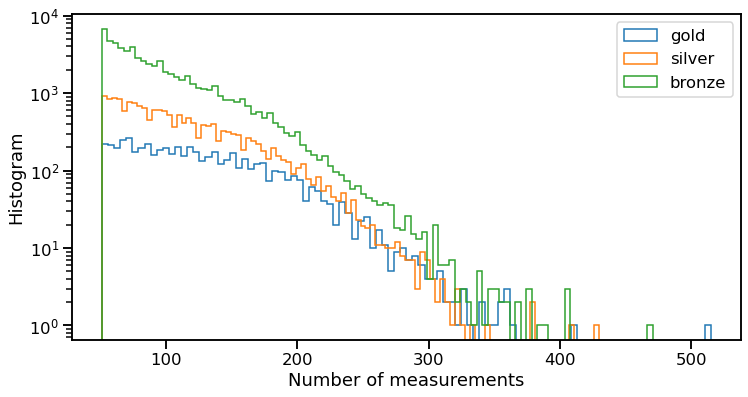

In [15]:
fig = plt.figure(figsize=(12, 6))

for flavor in ['gold', 'silver', 'bronze']:

    cond = data['flavor'] == flavor
    plt.hist(data.loc[cond, 'nmeasurements'], bins=100, histtype='step', label=flavor);
plt.xlabel('Number of measurements')
plt.ylabel('Histogram')
plt.yscale('log')
plt.legend();
fig.savefig(f'{data_fink}plots/nmeasurements.png', facecolor='white', dpi=150)

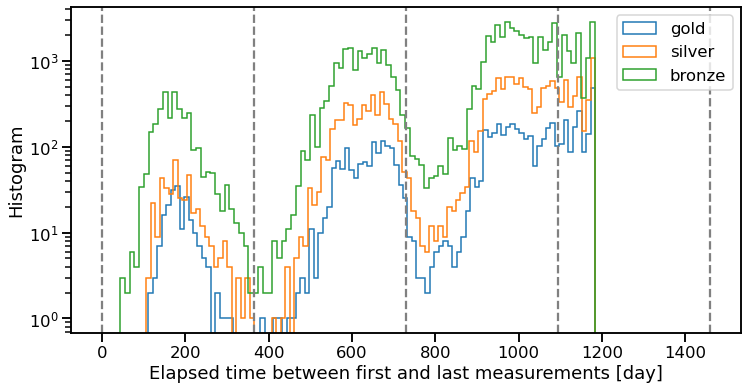

In [16]:
fig = plt.figure(figsize=(12, 6))

for flavor in ['gold', 'silver', 'bronze']:

    cond = data['flavor'] == flavor
    plt.hist(data.loc[cond, 'ndays'], bins=100, histtype='step', label=flavor);
plt.xlabel('Elapsed time between first and last measurements [day]')
plt.ylabel('Histogram');
plt.legend()
for i in range(5):
    plt.axvline(365*i, ls='--', color='grey')
plt.yscale('log')
fig.savefig(f'{data_fink}plots/time_lapse.png', facecolor='white', dpi=150)

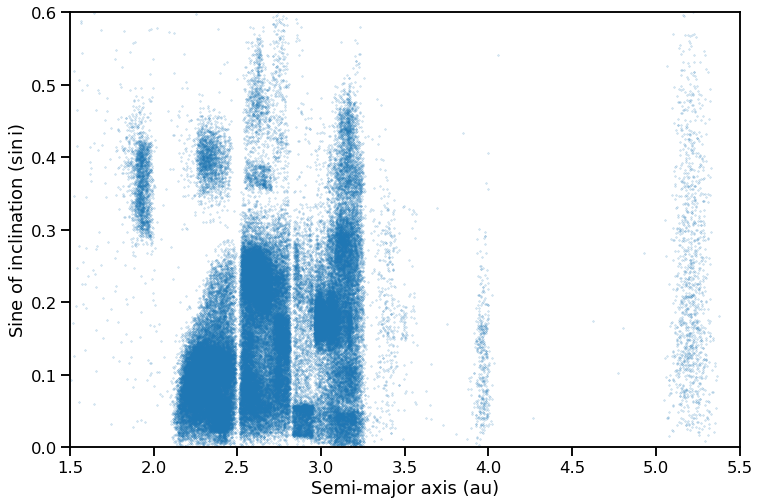

In [18]:
Is = data['orbital_elements.inclination.value']
As = data['orbital_elements.semi_major_axis.value']
Es = data['orbital_elements.eccentricity.value']

fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(As, np.sin(np.radians(Is)), marker='.', alpha=0.4, s=1);


ax.set_xlim(1.5,5.5)
ax.set_ylim(0, 0.6)
ax.set_xlabel('Semi-major axis (au)')
ax.set_ylabel(r'Sine of inclination ($\sin$i)')

fig.savefig(f'{data_fink}plots/types.png', facecolor='white', dpi=150)

In [19]:
data['sso_class'].value_counts()

MB>Middle             35384
MB>Inner              33246
MB>Outer              28455
Hungaria               1818
Phocaea                1481
Trojan                 1231
Mars-Crosser           1141
MB>Cybele               474
MB>Hilda                435
NEA>Apollo              158
NEA>Amor                132
NEA>Aten                 22
Centaur                   7
KBO>SDO                   7
KBO>Resonant>3:2          4
KBO>Classical>Main        4
KBO>Detached              2
KBO>Resonant>7:4          2
NEA>Atira                 1
KBO>Resonant>11:6         1
Name: sso_class, dtype: int64

## Phase curve

### Phase range - Phase Min - Phase Max

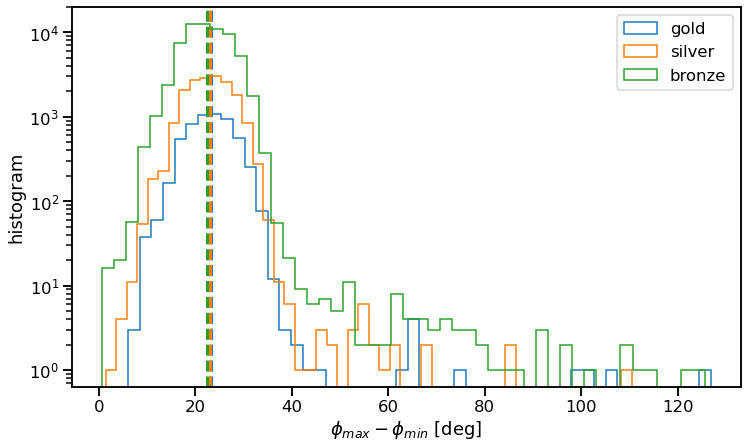

In [20]:
fig = plt.figure(figsize=(12, 7))

for index, flavor in enumerate(['gold', 'silver', 'bronze']):
    cond = data.flavor == flavor
    
    d_ = data.loc[cond,'maxphase'] - data.loc[cond,'minphase']

    plt.hist(d_, bins=50, histtype='step', density=False, label=flavor, color='C{}'.format(index))
    plt.axvline(np.mean(d_), ls='--', lw=3, color='C{}'.format(index))
    plt.xlabel(r'$\phi_{max} - \phi_{min}$ [deg]')
    plt.ylabel('histogram')
    plt.legend()
plt.yscale('log')
plt.show()
fig.savefig(f'{data_fink}plots/phase_amplitude.png', facecolor='white', dpi=150)

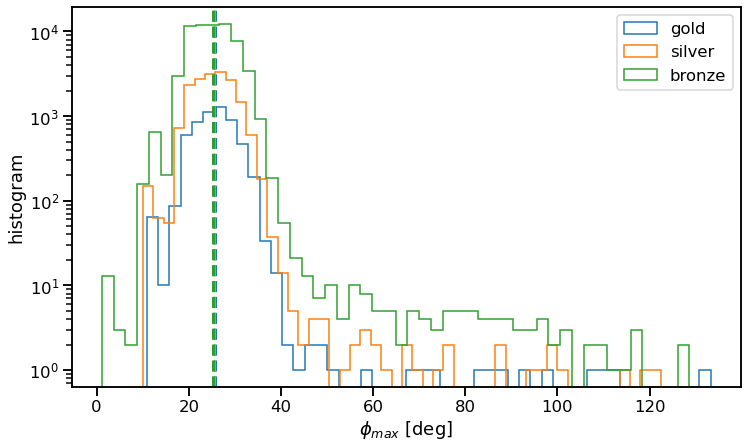

In [21]:
fig = plt.figure(figsize=(12, 7))

for index, flavor in enumerate(['gold', 'silver', 'bronze']):
    cond = data.flavor == flavor
    
    d_ = data.loc[cond,'maxphase'] 

    plt.hist(d_, bins=50, histtype='step', density=False, label=flavor, color='C{}'.format(index))
    plt.axvline(np.mean(d_), ls='--', lw=3, color='C{}'.format(index))
    plt.xlabel(r'$\phi_{max}$ [deg]')
    plt.ylabel('histogram')
    plt.legend()
plt.yscale('log')
plt.show()
fig.savefig(f'{data_fink}plots/phase_max.png', facecolor='white', dpi=150)

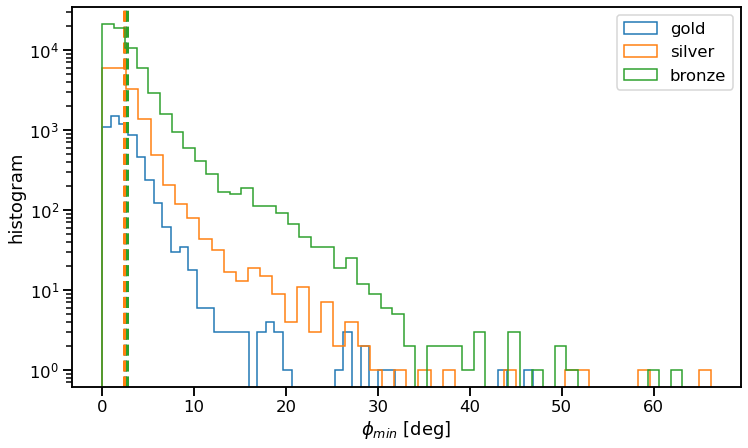

In [22]:
fig = plt.figure(figsize=(12, 7))

for index, flavor in enumerate(['gold', 'silver', 'bronze']):
    cond = data.flavor == flavor
    
    d_ = data.loc[cond,'minphase']

    plt.hist(d_, bins=50, histtype='step', density=False, label=flavor, color='C{}'.format(index))
    plt.axvline(np.mean(d_), ls='--', lw=3, color='C{}'.format(index))
    plt.xlabel(r'$\phi_{min}$ [deg]')
    plt.ylabel('histogram')
    plt.legend()
plt.yscale('log')
plt.show()
fig.savefig(f'{data_fink}plots/phase_min.png', facecolor='white', dpi=150)

### H - G1 - G2

G1 at 0 or 1 boundary: 25.8%
G1 at 0 or 1 boundary: 10.1%


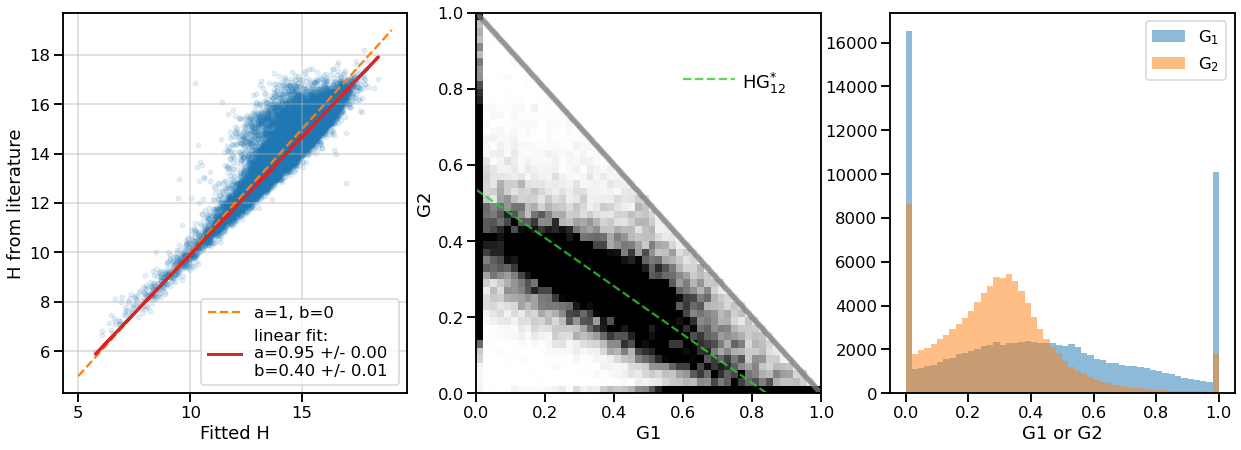

In [23]:
from scipy.optimize import curve_fit

def linear(x, a, b):
    return a * x + b

yaxis = data['phase_functions.Generic/Johnson.V.H.value'].values
mask = yaxis == yaxis
mask *= data['flavor'] == 'bronze'

xaxis = data['H'].values[mask]
yaxis = yaxis[mask]
err = data['dH'].values[mask]

popt, pcov = curve_fit(linear, xaxis, yaxis, sigma=err)
perr = np.sqrt(np.diagonal(pcov))


fig, ax = plt.subplots(1, 3, figsize=(21, 7))
ax[0].scatter(
    xaxis,
    yaxis,
    marker='.',
    alpha=0.1
)
ax[0].plot(
    range(5, 20), 
    range(5, 20), 
    color='C1', ls='--', label='a=1, b=0'
)
ax[0].plot(
    xaxis, 
    linear(xaxis, *popt), 
    label='linear fit: \na={:.2f} +/- {:.2f} \nb={:.2f} +/- {:.2f}'.format(popt[0], perr[0], popt[1], perr[1]),
    color='C3',
    lw=3
)
ax[0].set_xlabel('Fitted H')
ax[0].set_ylabel('H from literature')
ax[0].legend()
ax[0].grid(alpha=0.5)

def triangle(x, r):
    return r - x

# Scatter ----
# ax[1].scatter(
#     data.loc[mask,'G1'], 
#     data.loc[mask,'G2'], 
#     alpha=0.05, 
#     marker='.',
#     label='Fitted'
# )
# ax[1].scatter(
#     data.loc[mask,'phase_functions.Generic/Johnson.V.G1.value'], 
#     data.loc[mask,'phase_functions.Generic/Johnson.V.G2.value'], 
#     alpha=0.05, 
#     marker='.',
#     label='Literature'
# )

# histogram ----
ax[1].hist2d(
    data.loc[mask,'G1'], 
    data.loc[mask,'G2'], 
    # alpha=0.05, 
    # marker='.',
    range=[ [0,1],[0,1]], 
    bins=50,
    cmap='Greys',
    vmin=0, vmax=50, 
    label='Fitted'
)


g12 = np.linspace(0, 1, num=10)
G1, G2 = G12_to_G1G2(g12)
ax[1].plot(G1, G2, linestyle="--", color="limegreen", alpha=0.8)
ax[1].text(0.9, 0.8, "HG$_{12}^{*}$", ha="right")
ax[1].plot(
    [0.6, 0.75],
    [0.825, 0.825],
    linestyle="--",
    color="limegreen",
    alpha=0.8,
)

    
xr = np.arange(0, 1, 0.001)
ax[1].scatter(xr, triangle(xr, 1.), color='grey', marker='.', alpha=0.1)
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('G1')
ax[1].set_ylabel('G2')
# ax[1].legend()



binG = 50
ng1, hg1, _ = ax[2].hist( data['G1'], range=[0,1], bins=binG, alpha=0.5, label='G$_1$' )
ng2, hg2, _ = ax[2].hist( data['G2'], range=[0,1], bins=binG, alpha=0.5, label='G$_2$' )
ax[2].set_xlabel('G1 or G2')
ax[2].legend()

print(f'G1 at 0 or 1 boundary: {100*(ng1[0]+ng1[-1]) / np.sum(ng1):.1f}%' )
print(f'G1 at 0 or 1 boundary: {100*(ng2[0]+ng2[-1]) / np.sum(ng2):.1f}%' )

fig.savefig(f'{data_fink}plots/hg1g2.png', facecolor='white', dpi=150)

                 median   mean    std
H_V   - H_FINK:   0.079   0.175   0.549
H_V   - H_FINK:   0.135   0.263   0.532    bronze
H_V   - H_FINK:   0.101   0.199   0.446    silver
H_V   - H_FINK:   0.048   0.227   0.612    gold
H_MPC - H_V   :   0.351   0.363   0.185


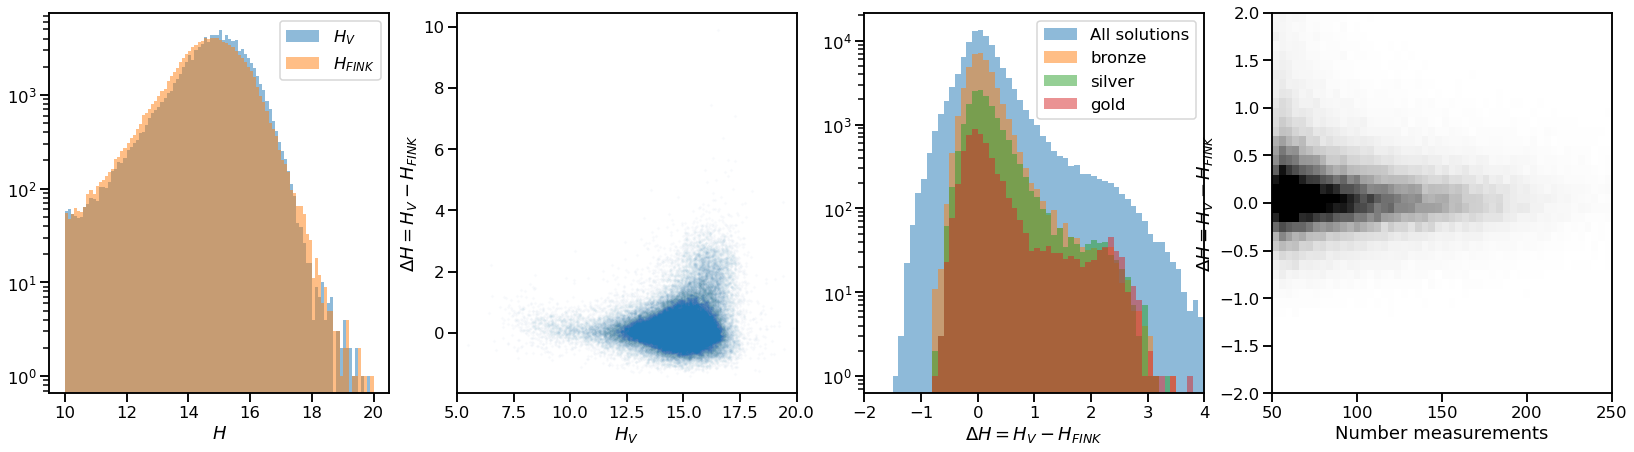

In [24]:
fig, ax = plt.subplots(1,4, figsize=(28,7))

ax[0].hist( data['absolute_magnitude.value'], range=[10,20], bins=100, alpha=0.5, label='$H_V$' )
ax[0].hist( data['H'], range=[10,20], bins=100, alpha=0.5, label='$H_{FINK}$' )
ax[0].set_xlabel('$H$')
ax[0].set_yscale('log')
ax[0].legend()


ax[1].scatter( data['absolute_magnitude.value'], data['absolute_magnitude.value']-data['H'], s=4, alpha=0.015 )
ax[1].set_xlabel('$H_V$')
ax[1].set_ylabel('$\\Delta H = H_V - H_{FINK}$')
ax[1].set_xlim(5,20)


ax[2].hist( data['absolute_magnitude.value']-data['H'], range=[-5,5], bins=100, alpha=0.5, label='All solutions' )

for f in ['bronze','silver','gold']:
    cond = (data['G1']>0.01) & (data['G2']>0.01) & (data.flavor==f)
    ax[2].hist( data.loc[cond,'absolute_magnitude.value']-data.loc[cond,'H'], range=[-5,5], bins=100, alpha=0.5,
               label=f'{f}' )
    
# cond = (data['G1']>0.01) & (data['G2']>0.01)
# ax[2].hist( data.loc[cond,'absolute_magnitude.value']-data.loc[cond,'H'], range=[-5,5], bins=100, alpha=0.5, label='Non-0 G1/G2' )
# ax[2].hist( data['absolute_magnitude.value']-data['phase_functions.Generic/Johnson.V.H.value'], range=[-5,5], bins=100 )

ax[2].set_xlabel('$\\Delta H = H_V - H_{FINK}$')
ax[2].set_yscale('linear')
ax[2].legend()
ax[2].set_xlim(-2,4)
ax[2].set_yscale('log')

ax[3].hist2d( data['nmeasurements'], data['absolute_magnitude.value']-data['H'],
             range=[[50,250], [-2,2]], bins=[ 50, 40], 
             cmap='Greys', 
             vmax=500)
ax[3].set_xlabel('Number measurements')
ax[3].set_ylabel('$\\Delta H = H_V - H_{FINK}$')


print('                 median   mean    std')
deltaH = data['absolute_magnitude.value']-data['H']
print( 'H_V   - H_FINK:  {:6.3f}  {:6.3f}  {:6.3f}'.format(np.nanmedian(deltaH), np.mean(deltaH), np.std(deltaH) ))

for f in ['bronze','silver','gold']:
    # cond = (data['G1']>0.01) & (data['G2']>0.01) & (data.flavor==f)
    cond = (data.flavor==f)
    deltaH = data.loc[cond,'absolute_magnitude.value']-data.loc[cond,'H']
    print( 'H_V   - H_FINK:  {:6.3f}  {:6.3f}  {:6.3f}    {:}'.format(np.nanmedian(deltaH), np.mean(deltaH), np.std(deltaH), f ))

deltaH_V = data['absolute_magnitude.value']-data['phase_functions.Generic/Johnson.V.H.value']
print( 'H_MPC - H_V   :  {:6.3f}  {:6.3f}  {:6.3f}'.format(np.nanmedian(deltaH_V), np.mean(deltaH_V), np.std(deltaH_V) ))

fig.savefig(f'{data_fink}plots/Hv_vs_HFINK.png', facecolor='white', dpi=150)

### Goodness of fit

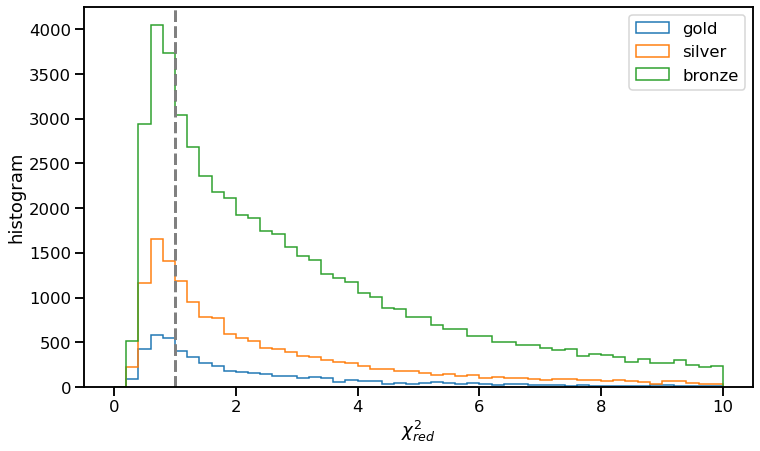

In [25]:
fig = plt.figure(figsize=(12, 7))

for flavor in ['gold', 'silver', 'bronze']:
    cond = data['flavor'] == flavor

    plt.hist(data.loc[cond,'chi2red'], bins=50, histtype='step', density=False, range=[0,10], label=flavor)
    plt.axvline(1, ls='--', color='grey', lw=3)
    plt.xlabel(r'$\chi^2_{red}$')
    plt.ylabel('histogram')
    plt.legend()
plt.show()
fig.savefig(f'{data_fink}plots/chi2.png', facecolor='white', dpi=150)

(0.0, 10.0)

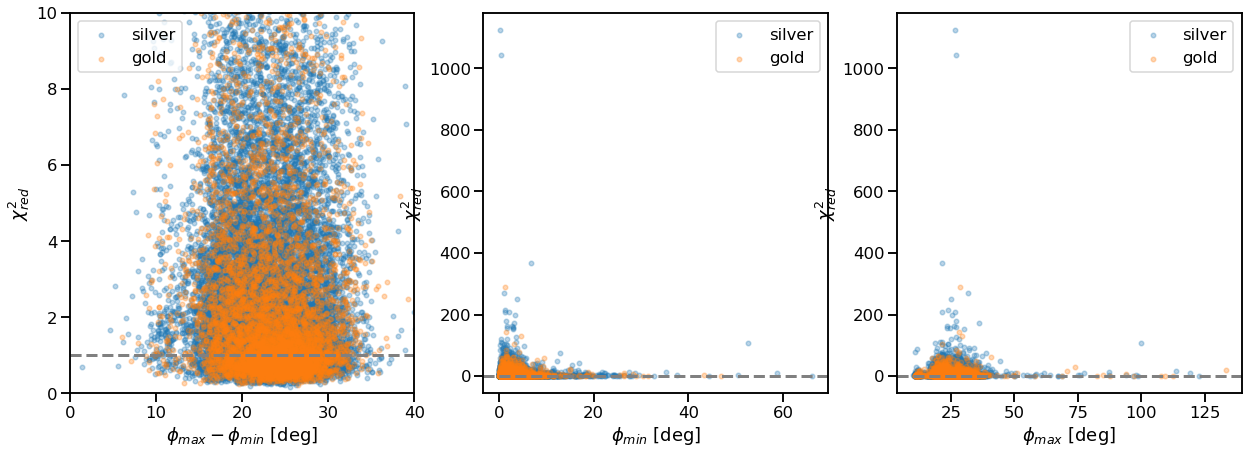

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

for flavor in ['silver', 'gold']:
    cond = data['flavor'] == flavor
    
    d_1 = data.loc[cond,'maxphase'] - data.loc[cond,'minphase']
    d_2 = data.loc[cond,'chi2red']
    ax[0].scatter(
        d_1,
        d_2,
        marker='.',
        alpha=0.3,
        label=flavor,
    )
    ax[0].set_xlabel(r'$\phi_{max} - \phi_{min}$ [deg]')

    d_1 = data.loc[cond,'minphase']
    d_2 = data.loc[cond,'chi2red']
    ax[1].scatter(
        d_1,
        d_2,
        marker='.',
        alpha=0.3,
        label=flavor,
    )
    ax[1].set_xlabel(r'$\phi_{min}$ [deg]')

    d_1 = data.loc[cond,'maxphase']
    d_2 = data.loc[cond,'chi2red']
    ax[2].scatter(
        d_1,
        d_2,
        marker='.',
        alpha=0.3,
        label=flavor,
    )
    ax[2].set_xlabel(r'$\phi_{max}$ [deg]')

    
for a in ax:
    a.axhline(1, ls='--', color='grey', lw=3)
    a.set_ylabel(r'$\chi^2_{red}$')
    a.legend()

    
    
    
ax[0].set_xlim([0, 40])
ax[0].set_ylim([0, 10])
# plt.show()

Interesting -- the chi2 value does not depend on the phase range.

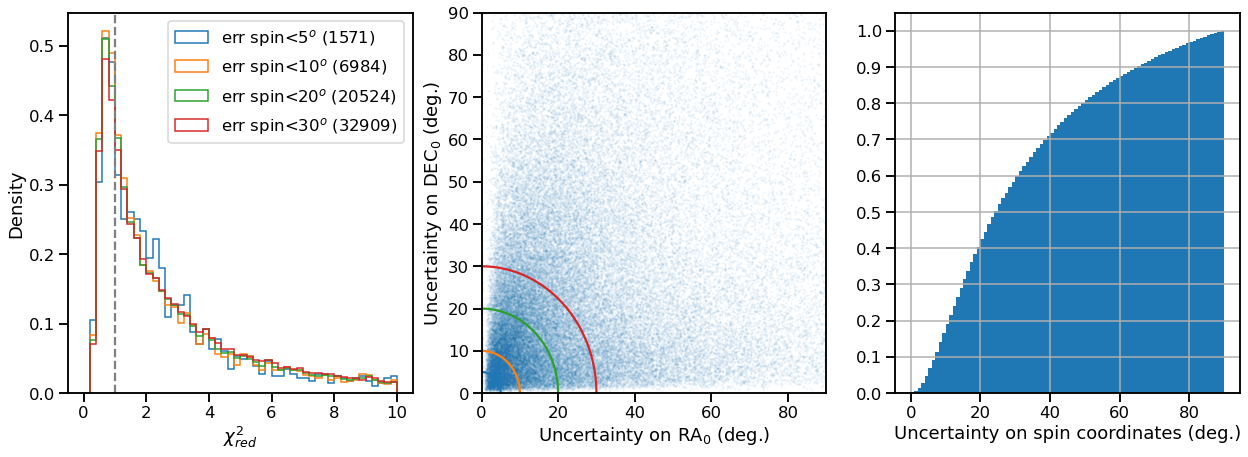

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(21,7))


for err in [5,10,20,30]:
    cond = data.dSpin<=err
    ax[0].hist(data.loc[cond,'chi2red'], bins=50, histtype='step', density=True, range=[0,10], label=f'err spin<{err:d}$^o$ ({len(data[cond])})')

    theta = np.linspace(0, np.pi/2, num=90 )
    ax[1].plot( err*np.cos(theta), err*np.sin(theta) )
    
ax[0].axvline(1, ls='--', color='grey')
ax[0].set_xlabel(r'$\chi^2_{red}$')
ax[0].set_ylabel('Density')
ax[0].legend()



ax[1].scatter( data.dRA0, data.dDEC0, s=1, alpha=0.05 )
ax[1].set_xlim(0,90)
ax[1].set_ylim(0,90)

ax[1].set_xlabel('Uncertainty on RA$_0$ (deg.)')
ax[1].set_ylabel('Uncertainty on DEC$_0$ (deg.)')

circ_err = np.sqrt( (data.dRA0*np.cos(np.radians(data.DEC0)) )**2 + data.dDEC0**2 )
ax[2].hist( circ_err, cumulative=True, density=True, range=[0,90], bins=90 )
# ax[2].axhline(0.5, linestyle='--', color='gray' )
ax[2].grid()
ax[2].set_yticks(np.linspace(0,1,num=11))
ax[2].set_xlabel('Uncertainty on spin coordinates (deg.)')

fig.savefig(f'{data_fink}plots/uncertainties_spin.png', facecolor='white', dpi=150)
plt.show()

## Spin distance

In [28]:
# Compute angular distances
spin_version = np.array(['A','B'])

for ks in ['1','2','3','4']:
    data[f'spins.{ks}.distance'] = np.nan
    cond = (~data[f'spins.{ks}.RA0.value'].isna())
    
    #------------------------------------------------------------------------------------------
    # A: Original spins
    data.loc[cond,f'spins.{ks}.distance.A'] = data.loc[cond,[f'spins.{ks}.RA0.value',f'spins.{ks}.DEC0.value', 'RA0','DEC0']].apply(
        lambda x: np.degrees(angular_separation( np.radians(x[0]), np.radians(x[1]), np.radians(x[2]), np.radians(x[3]) )) , axis=1
    )
    data.loc[cond,f'spins.{ks}.delta_RA.A'] = (data.loc[cond,f'spins.{ks}.RA0.value']-data.loc[cond,'RA0'] ) * np.cos(np.radians(data.loc[cond,f'spins.{ks}.DEC0.value']))
    data.loc[cond,f'spins.{ks}.delta_DEC.A'] = (data.loc[cond,f'spins.{ks}.DEC0.value']-data.loc[cond,'DEC0'] )

    #------------------------------------------------------------------------------------------
    # B: RA-180 & Flip DEC
    data.loc[cond,f'spins.{ks}.distance.B'] = data.loc[cond,[f'spins.{ks}.RA0.value',f'spins.{ks}.DEC0.value', 'RA0','DEC0']].apply(
        lambda x: np.degrees(angular_separation( np.radians(x[0]-180), np.radians(-x[1]), np.radians(x[2]), np.radians(x[3]) )) , axis=1
    )
    data.loc[cond,f'spins.{ks}.delta_RA.B'] = (data.loc[cond,f'spins.{ks}.RA0.value']-180.0-data.loc[cond,'RA0'] ) * np.cos(np.radians(-data.loc[cond,f'spins.{ks}.DEC0.value']))
    data.loc[cond,f'spins.{ks}.delta_DEC.B'] = (-data.loc[cond,f'spins.{ks}.DEC0.value']-data.loc[cond,'DEC0'] )

    #------------------------------------------------------------------------------------------
    # Find minimum distance and keep track of which spin version it is
    data.loc[cond,f'spins.{ks}.closest'] = data.loc[cond, [f'spins.{ks}.distance.A', 
                                                           f'spins.{ks}.distance.B']].apply( lambda x: int(np.argmin(x)), axis=1 )
    data = data.astype({f'spins.{ks}.closest':'Int64'})

    data.loc[cond,f'spins.{ks}.distance'] = data.loc[cond, [f'spins.{ks}.distance.A', 
                                                            f'spins.{ks}.distance.B']].apply( lambda x: np.min(x), axis=1 )
    data.loc[cond,f'spins.{ks}.version'] = data.loc[cond, [f'spins.{ks}.distance.A', 
                                                           f'spins.{ks}.distance.B']].apply( lambda x: spin_version[np.argmin(x)], axis=1 )

    #------------------------------------------------------------------------------------------
    # Find minimum distance and keep track of which spin version it is
    data.loc[cond,f'spins.{ks}.delta_RA'] = data.loc[cond, [f'spins.{ks}.delta_RA.A',
                                                            f'spins.{ks}.delta_RA.B', 
                                                            f'spins.{ks}.closest']].apply( lambda x: x[int(x[2])], axis=1 )
    data.loc[cond,f'spins.{ks}.delta_DEC'] = data.loc[cond, [f'spins.{ks}.delta_DEC.A',
                                                             f'spins.{ks}.delta_DEC.B', 
                                                             f'spins.{ks}.closest']].apply( lambda x: x[int(x[2])], axis=1 )

    
# Select the closest angularly
cond = ~data[f'spins.1.distance'].isna()
data.loc[cond,'spins.closest'] = data.loc[cond,['spins.1.distance','spins.2.distance','spins.3.distance','spins.4.distance']].apply( lambda x: int(np.argmin(x)), axis=1 )
data = data.astype({'spins.closest':'Int64'})

data.loc[cond,'spins.distance'] = data.loc[cond,['spins.1.distance','spins.2.distance','spins.3.distance','spins.4.distance']].apply( lambda x: np.min(x), axis=1 )
data.loc[cond,'spins.delta_RA'] = data.loc[cond, [f'spins.1.delta_RA',
                                                  f'spins.2.delta_RA',
                                                  f'spins.3.delta_RA',
                                                  f'spins.4.delta_RA', 
                                                  f'spins.closest']].apply( lambda x: x[int(x[4])], axis=1 )
data.loc[cond,'spins.delta_DEC'] = data.loc[cond, [f'spins.1.delta_DEC',
                                                   f'spins.2.delta_DEC',
                                                   f'spins.3.delta_DEC',
                                                   f'spins.4.delta_DEC', 
                                                   f'spins.closest']].apply( lambda x: x[int(x[4])], axis=1 )



In [ ]:
# cond = ~data[f'spins.1.distance'].isna()
# cols = data.columns[data.columns.str.contains('distance')].to_list()+['spins.closest']+data.columns[data.columns.str.contains('delta')].to_list()
# cols = [',', 'spins.1.delta_RA.A','spins.1.delta_RA.B','spins.1.delta_RA.C','spins.1.delta_RA.D', 'spins.delta_RA']
# cols = cols[1:]

# data.loc[cond, cols]

Available spins: 2,752


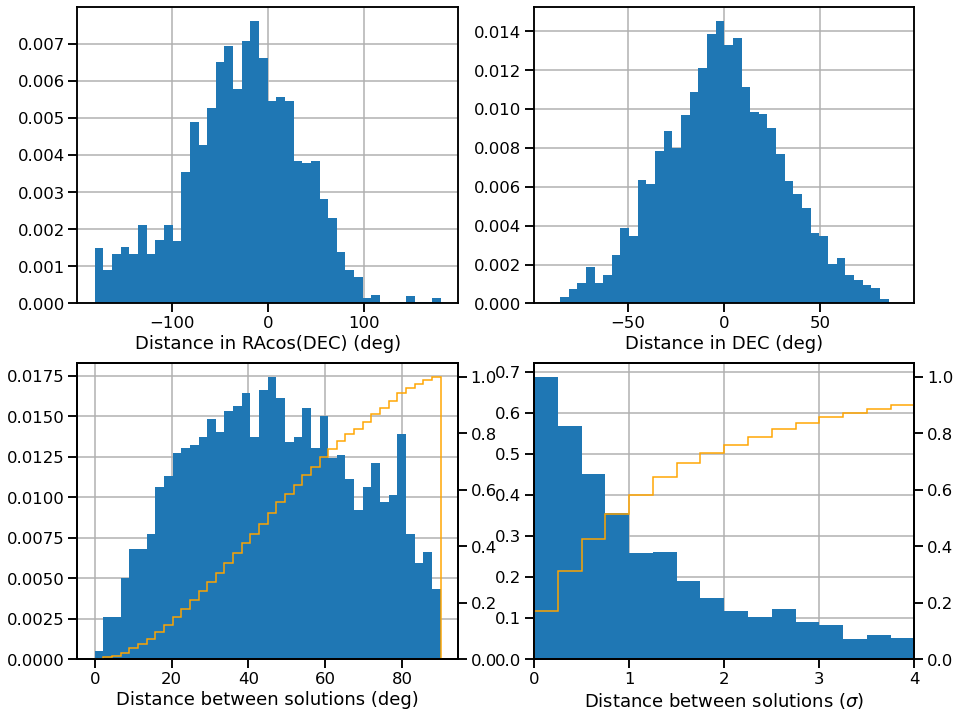

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(15, 12))


cond = data['spins.closest']>=0
# cond *= data['flavor'] == 'bronze'
# cond *= data['flavor'] != 'toto'

print('Available spins: {:,}'.format(np.sum(cond)))

id_closest = data.loc[cond,'spins.closest'].astype('str')


nbins = 40
ax[0, 0].hist( data.loc[cond, 'spins.delta_RA'], range=[-180,180], bins=nbins, density=True )
ax[0, 1].hist( data.loc[cond, 'spins.delta_DEC'], range=[-90,90], bins=nbins, density=True )

ax[1, 0].hist( data.loc[cond, 'spins.distance'], range=[0,90], bins=nbins, density=True )
ax2 = ax[1, 0].twinx()
ax2.hist( data.loc[cond, 'spins.distance'], range=[0,90], bins=nbins, density=True , cumulative=True, histtype='step', color='orange')

ax[1, 1].hist( data.loc[cond, 'spins.distance']/data.dSpin, range=[0,10], bins=nbins, density=True )
ax3 = ax[1, 1].twinx()
ax3.hist( data.loc[cond, 'spins.distance']/data.dSpin, range=[0,10], bins=nbins, density=True, cumulative=True, histtype='step', color='orange' )
ax[1, 1].set_xlim(0,4)


ax[0, 0].set_xlabel('Distance in RAcos(DEC) (deg)')
ax[0, 1].set_xlabel('Distance in DEC (deg)')
ax[1, 0].set_xlabel('Distance between solutions (deg)')
ax[1, 1].set_xlabel('Distance between solutions ($\\sigma$)')



for a in ax:
    for a_ in a:
        a_.grid()
        a_.set_axisbelow(True)

fig.savefig(f'{data_fink}plots/fig_spins_validation.png', facecolor='white')
plt.show()

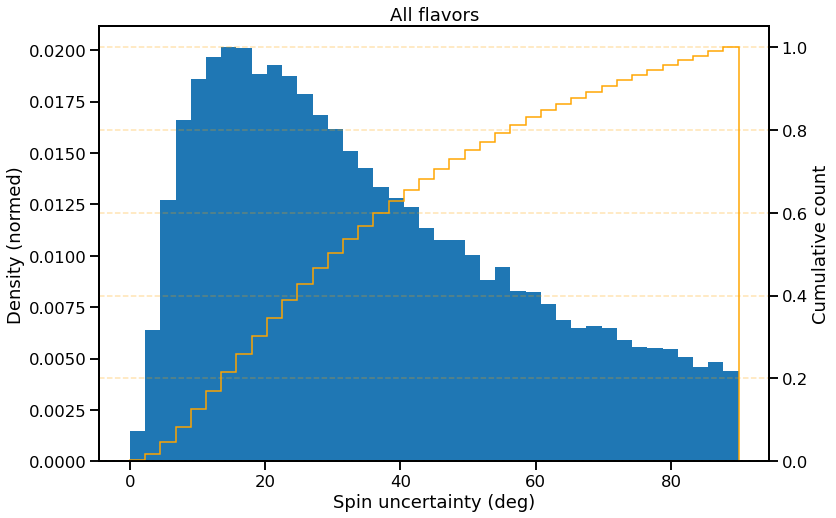

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.hist( data.dSpin, range=[0,90], bins=nbins, density=True,  )
ax0 = ax.twinx()

ax0.hist( data.dSpin, range=[0,90], bins=nbins, density=True, cumulative=True, histtype='step', color='orange' )

ax.set_xlabel('Spin uncertainty (deg)')
ax.set_ylabel('Density (normed)')
ax0.set_ylabel('Cumulative count')

ax0.grid(color='orange', alpha=0.3, ls='--')
ax.set_title('All flavors')
ax.set_axisbelow(True)
fig.savefig(f'{data_fink}plots/spin_uncertainty.png', facecolor='white', dpi=150)
plt.show()

### RA0

Number of observations for gold   :  5637/104005
Number of observations for silver : 17602/104005
Number of observations for bronze : 64160/104005


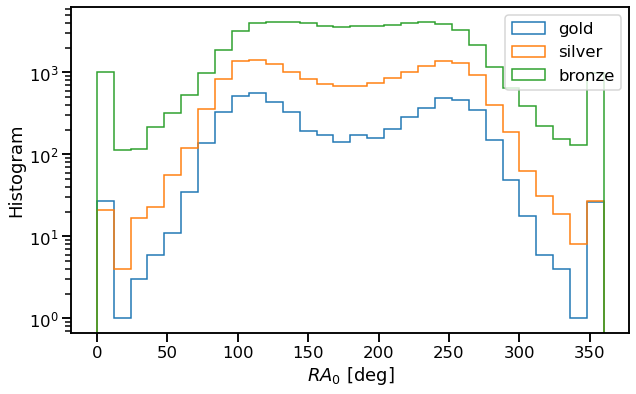

In [31]:
fig = plt.figure(figsize=(10, 6))
for flavor in ['gold', 'silver', 'bronze']:

    cond = data['flavor'] == flavor
    print('Number of observations for {:7s}: {:5d}/{:5d}'.format(flavor, len(data[cond]), len(data)))
    plt.hist(
        data.loc[cond, 'RA0'], 
        bins=30,
        histtype='step', 
        label=flavor, 
        density=False
    )
    
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel(r'$RA_0$ [deg]')
plt.ylabel('Histogram')
plt.savefig(f'{data_fink}plots/ra0.png', dpi=150)
plt.show()

### Distribution of Spin EC & EQ coordinates & obliquity 

Number of observations for gold   :  5637/104005
Number of observations for silver : 17602/104005
Number of observations for bronze : 64160/104005


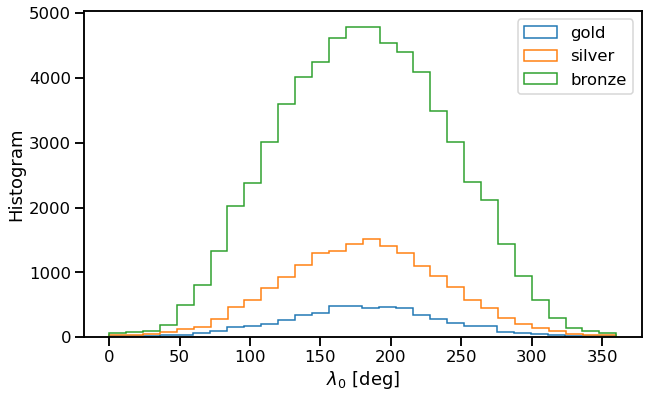

In [32]:
fig = plt.figure(figsize=(10, 6))
for flavor in ['gold', 'silver', 'bronze']:

    cond = data['flavor'] == flavor
    print('Number of observations for {:7s}: {:5d}/{:5d}'.format(flavor, len(data[cond]), len(data)))
    plt.hist(
        data.loc[cond, 'lon'], 
        bins=30,
        histtype='step', 
        label=flavor, 
        density=False
    )
    
# plt.yscale('log')
plt.legend(loc='best')
plt.xlabel(r'$\lambda_0$ [deg]')
plt.ylabel('Histogram')
plt.savefig(f'{data_fink}plots/lon.png', dpi=150)
plt.show()

The figure here above is **super** suspicious. The reason is the following: we have a 180deg. degeneracy in spin. So we should always randomize 50% of the sample and flip their spin coordinate by 180 deg on the sphere

Number of observations for gold   :  5637/104005
Number of observations for silver : 17602/104005
Number of observations for bronze : 64160/104005


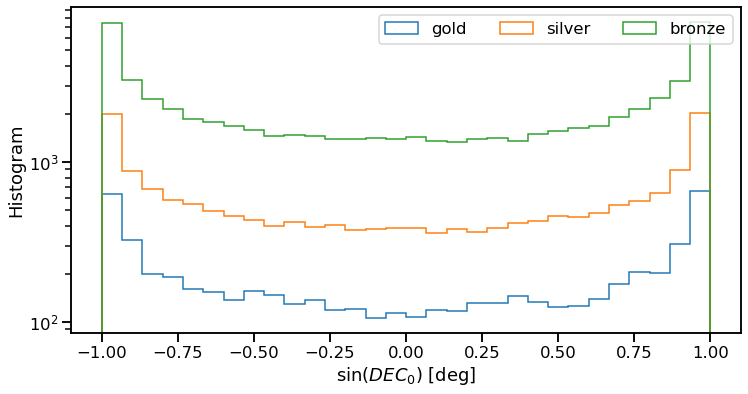

In [33]:
fig = plt.figure(figsize=(12, 6))
for flavor in ['gold', 'silver', 'bronze']:

    cond = data['flavor'] == flavor
    print('Number of observations for {:7s}: {:5d}/{:5d}'.format(flavor, len(data[cond]), len(data)))
    plt.hist(
        np.sin(data.loc[cond, 'DEC0']), 
        bins=30,
        histtype='step', 
        label=flavor, 
        density=False
    )
    
plt.yscale('log')
plt.legend(loc='best', ncol=3)
plt.xlabel(r'$\sin(DEC_0)$ [deg]')
plt.ylabel('Histogram')
plt.savefig(f'{data_fink}plots/sindec0.png', dpi=150)
plt.show()

Number of observations for gold   :  5637/104005
Number of observations for silver : 17602/104005
Number of observations for bronze : 64160/104005


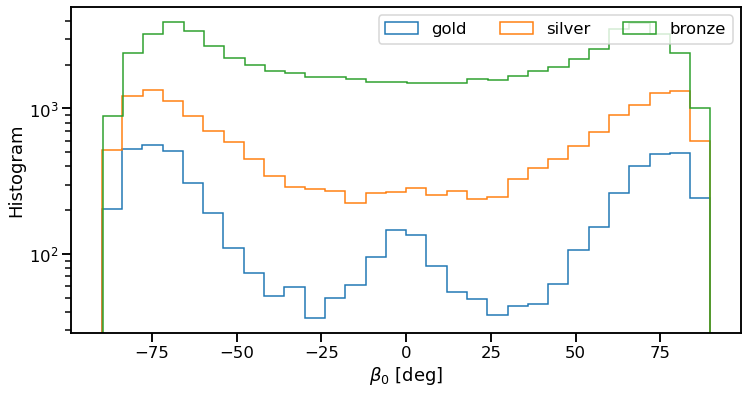

In [34]:
fig = plt.figure(figsize=(12, 6))
for flavor in ['gold', 'silver', 'bronze']:

    cond = data['flavor'] == flavor
    print('Number of observations for {:7s}: {:5d}/{:5d}'.format(flavor, len(data[cond]), len(data)))
    plt.hist(
        # np.sin(data.loc[cond, 'lat']), 
        data.loc[cond, 'lat'], 
        bins=30,
        histtype='step', 
        label=flavor, 
        density=False
    )
    
plt.yscale('log')
plt.legend(loc='best', ncol=3)
plt.xlabel(r'$\beta_0$ [deg]')
plt.ylabel('Histogram')
plt.savefig(f'{data_fink}plots/lat0.png', dpi=150)
plt.show()

Number of observations for gold   :  5637/104005
Number of observations for silver : 17602/104005
Number of observations for bronze : 64160/104005


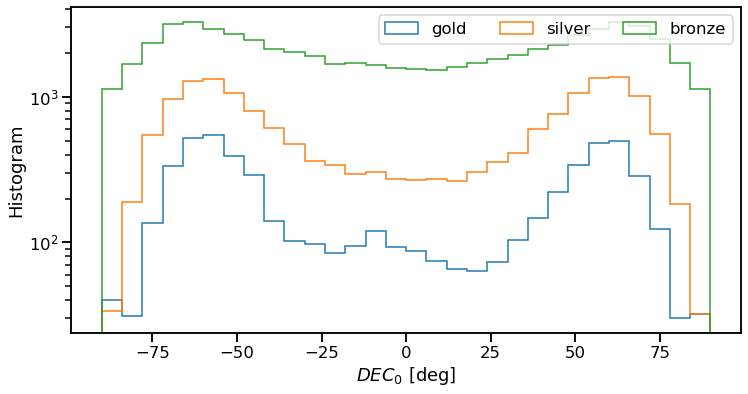

In [35]:
fig = plt.figure(figsize=(12, 6))
for flavor in ['gold', 'silver', 'bronze']:

    cond = data['flavor'] == flavor
    print('Number of observations for {:7s}: {:5d}/{:5d}'.format(flavor, len(data[cond]), len(data)))
    plt.hist(
        data.loc[cond, 'DEC0'], 
        bins=30,
        histtype='step', 
        label=flavor, 
        density=False
    )
    
plt.yscale('log')
plt.legend(loc='best', ncol=3)
plt.xlabel(r'$DEC_0$ [deg]')
plt.ylabel('Histogram')
plt.savefig(f'{data_fink}plots/dec0.png', dpi=150)
plt.show()

Number of observations for gold   :  5637/104005
Number of observations for silver : 17602/104005
Number of observations for bronze : 64160/104005


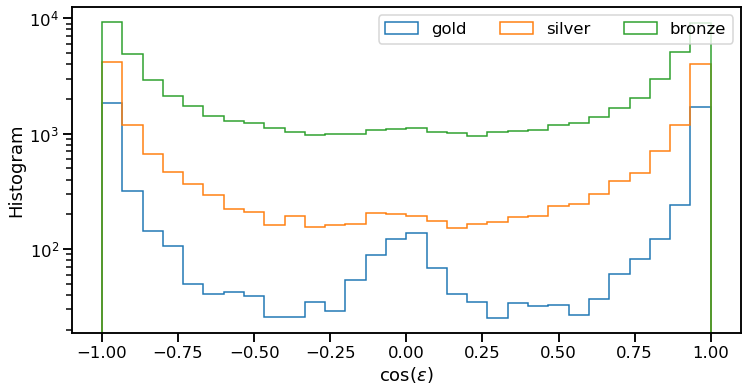

In [36]:
fig = plt.figure(figsize=(12, 6))
for flavor in ['gold', 'silver', 'bronze']:

    cond = data['flavor'] == flavor
    print('Number of observations for {:7s}: {:5d}/{:5d}'.format(flavor, len(data[cond]), len(data)))
    plt.hist(
        np.cos(np.radians(data.loc[cond, 'obliquity'])), 
        bins=30,
        histtype='step', 
        label=flavor, 
        density=False
    )
    
plt.yscale('log')
plt.legend(loc='best', ncol=3)
plt.xlabel(r'$\cos(\epsilon)$')
plt.ylabel('Histogram')
plt.savefig(f'{data_fink}plots/hist_obliquity.png', dpi=150)
plt.show()

### Oblateness

Number of observations for gold   :  2979/104005
Number of observations for silver :  9658/104005
Number of observations for bronze : 33156/104005


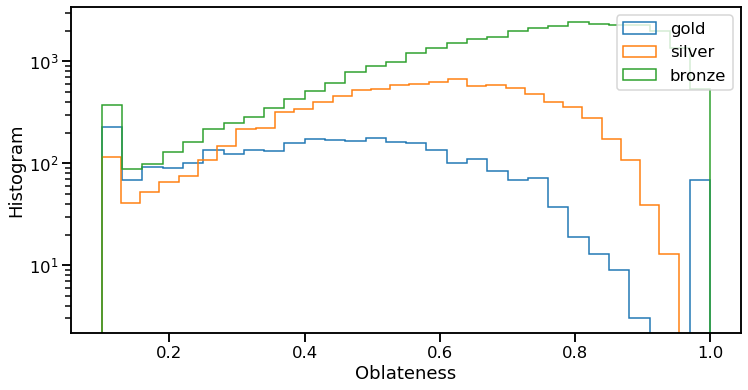

In [37]:
fig = plt.figure(figsize=(12, 6))
for flavor in ['gold', 'silver', 'bronze']:

    cond = data['flavor'] == flavor
    cond *= data['R']/data['dR'] > 1
    print('Number of observations for {:7s}: {:5d}/{:5d}'.format(flavor, len(data[cond]), len(data)))
    plt.hist(
        data.loc[cond, 'R'], 
        bins=30,
        histtype='step', 
        label=flavor, 
        density=False
    )
    
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel(r'Oblateness')
plt.ylabel('Histogram')
plt.savefig(f'{data_fink}plots/R.png', dpi=150)
plt.show()

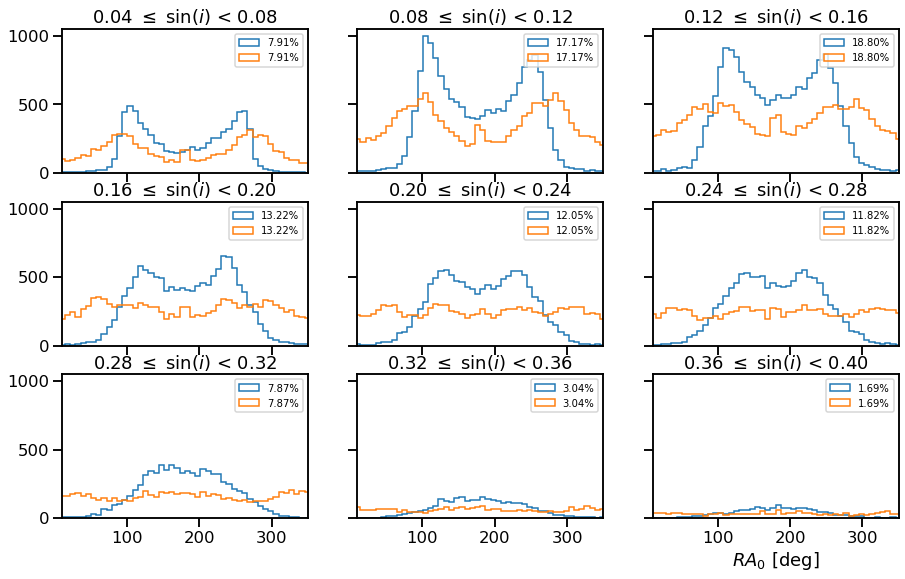

In [39]:
Is = np.sin(np.deg2rad(data['orbital_elements.inclination.value']))

fig, ax = plt.subplots(3, 3, figsize=(15, 9), sharex=True, sharey=True)
m1 = data['flavor'] == 'gold'
m = data['flavor'] != 'toto'


# Flip every second spin
cond = (data.index %2 ==0 )
data['RA0_flip'] = data['RA0']
data.loc[cond,'RA0_flip'] = (data.loc[cond,'RA0']-180) % 360


step = 0.04
count = 0
for i in range(0, 3):
    for j in range(0, 3):

        mi = (Is[m] >= count*step) * (Is[m] < (count+1)*step)
        ax[i, j].hist(
            data['RA0'][m][mi], 
            bins=50, 
            density=False,
            histtype='step', 
            label='{:.2f}%'.format(len(data['RA0'][m][mi])/len(data['RA0'][m]) * 100)
        )
        ax[i, j].hist(
            data['RA0_flip'][m][mi], 
            bins=50, 
            density=False,
            histtype='step', 
            label='{:.2f}%'.format(len(data['RA0'][m][mi])/len(data['RA0'][m]) * 100)
        )

        count += 1
        ax[i, j].set_title(r'{:.2f} $\leq$ $\sin(i)$ < {:.2f}'.format(count*step, (count+1)*step))
        ax[i, j].set_xlim(10, 350)

        # only on the last one
        ax[i, j].legend(fontsize=10)
plt.xlabel(r'$RA_0$ [deg]')
# plt.yscale('log')
fig.savefig(f'{data_fink}plots/ra0_vs_incl_distrib.png', facecolor='white', dpi=150)
plt.show()

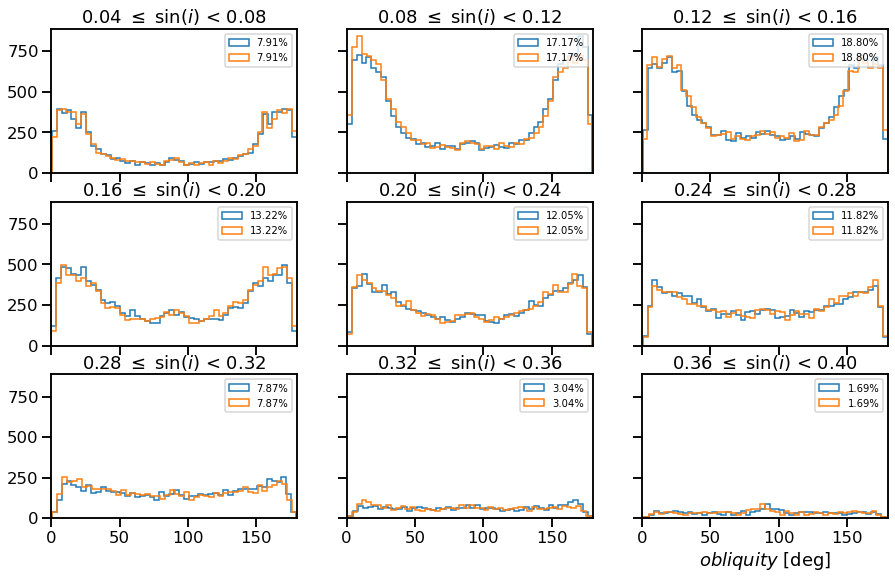

In [42]:
Is = np.sin(np.deg2rad(data['orbital_elements.inclination.value']))

fig, ax = plt.subplots(3, 3, figsize=(15, 9), sharex=True, sharey=True)
m1 = data['flavor'] == 'gold'
m = data['flavor'] != 'toto'



step = 0.04
count = 0
for i in range(0, 3):
    for j in range(0, 3):

        mi = (Is[m] >= count*step) * (Is[m] < (count+1)*step)
        ax[i, j].hist(
            data['obliquity'][m][mi], 
            bins=50, 
            density=False,
            histtype='step', 
            label='{:.2f}%'.format(len(data['RA0'][m][mi])/len(data['RA0'][m]) * 100)
        )
        ax[i, j].hist(
            data['obliquity_alt'][m][mi], 
            bins=50, 
            density=False,
            histtype='step', 
            label='{:.2f}%'.format(len(data['RA0'][m][mi])/len(data['RA0'][m]) * 100)
        )

        count += 1
        ax[i, j].set_title(r'{:.2f} $\leq$ $\sin(i)$ < {:.2f}'.format(count*step, (count+1)*step))
        ax[i, j].set_xlim(0,180)

        # only on the last one
        ax[i, j].legend(fontsize=10)
        
plt.xlabel(r'$obliquity$ [deg]')
# plt.yscale('log')
fig.savefig(f'{data_fink}plots/obliquity_vs_incl_distrib_with_flip.png', facecolor='white', dpi=150)
plt.show()

Not sure to understand why the obliquity anisotropy is more marked for objects with low inclinaison. There are some article on that with D. Vokrouhlicky. Let's double check. 

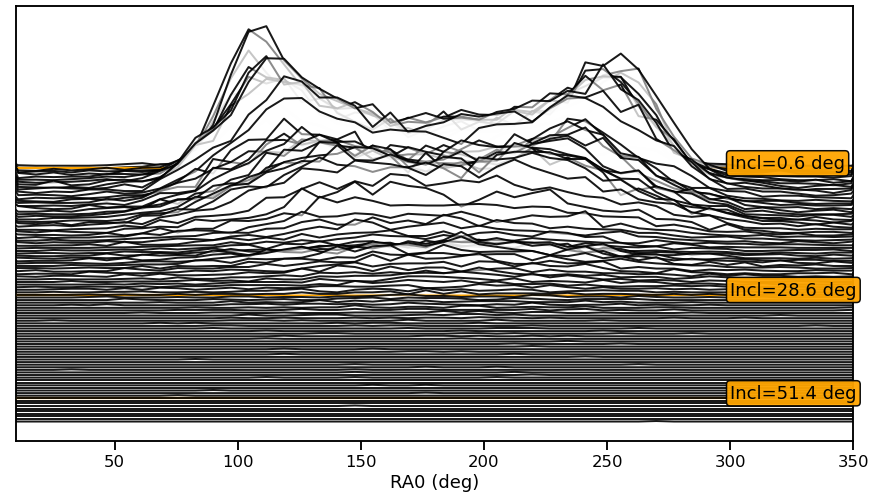

In [41]:
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

# cond = data['flavor'] == 'silver'
cond = data['RA0'] == data['RA0']

d_1 = data.loc[cond,'RA0']
Is = np.sin(np.deg2rad(data['orbital_elements.inclination.value']))
d_2 = Is[cond]

H, x, y = np.histogram2d(d_1, d_2, bins=(50, 100))

nx = len(H)
ny = len(H[0])
fig = plt.figure(figsize=(15, 8), facecolor='w')
ax = fig.add_subplot(111)
maxs = []
for iy in range(ny):
    # Offset each line by this amount: we want the first lines plotted
    # at the top of the chart and to work our way down
    offset = (ny-iy)*5
    # Plot the line and fill under it: increase the z-order each time
    # so that lower lines and their fills are plotted over higher ones
#     yhat = savgol_filter(H.T[iy], 7, 3)
    yhat = H.T[iy]
    xcenters = (x[:-1] + x[1:]) / 2
    ax.plot(xcenters, yhat+offset, 'k', lw=2, zorder=(iy+1)*2, alpha=0.9)
    ax.fill_between(xcenters, yhat+offset, offset, facecolor='w', lw=0, zorder=(iy+1)*2-1, alpha=0.5)
    if np.max(yhat) > 1.1 * np.mean(yhat):
        max_ = np.argmax(yhat)
        maxs.append([xcenters[max_], yhat[max_]])
ax.get_yaxis().set_visible(False)

for incl in [10, int(ny/2), ny-1]:
    ax.text(300, offset*incl, 'Incl={:.1f} deg'.format(np.rad2deg(y[::-1][:-1][incl])), color='black', 
        bbox=dict(facecolor='orange', edgecolor='black', boxstyle='round,pad=0.2', alpha=0.95), zorder=1e6)
    plt.axhline(offset*incl, color='orange', zorder=5)
plt.xlim(10, 350)
plt.xlabel('RA0 (deg)')
fig.savefig(f'{data_fink}plots/ra0_vs_incl_waterfall.png', facecolor='white', dpi=150)
plt.show()

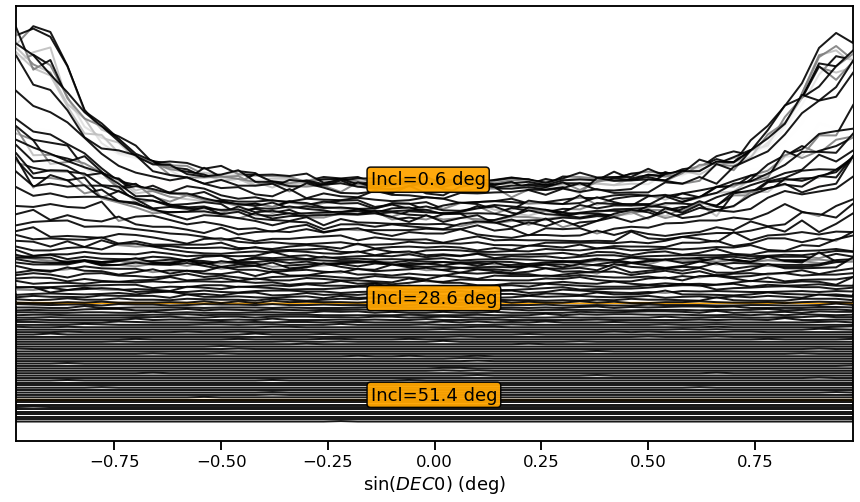

In [43]:
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

# cond = data['flavor'] == 'silver'
cond = data['RA0'] == data['RA0']

d_1 = np.sin(np.deg2rad(data.loc[cond,'DEC0']))
d_2 = Is[cond]

H, x, y = np.histogram2d(d_1, d_2, bins=(50, 100))

nx = len(H)
ny = len(H[0])
fig = plt.figure(figsize=(15, 8), facecolor='w')
ax = fig.add_subplot(111)
maxs = []
for iy in range(ny):
    # Offset each line by this amount: we want the first lines plotted
    # at the top of the chart and to work our way down
    offset = (ny-iy)*5
    # Plot the line and fill under it: increase the z-order each time
    # so that lower lines and their fills are plotted over higher ones
#     yhat = savgol_filter(H.T[iy], 7, 3)
    yhat = H.T[iy]
    xcenters = (x[:-1] + x[1:]) / 2
    ax.plot(xcenters, yhat+offset, 'k', lw=2, zorder=(iy+1)*2, alpha=0.9)
    ax.fill_between(xcenters, yhat+offset, offset, facecolor='w', lw=0, zorder=(iy+1)*2-1, alpha=0.5)
    if np.max(yhat) > 1.1 * np.mean(yhat):
        max_ = np.argmax(yhat)
        maxs.append([xcenters[max_], yhat[max_]])
ax.get_yaxis().set_visible(False)

for incl in [10, int(ny/2), ny-1]:
    ax.text(-0.15, offset*incl, 'Incl={:.1f} deg'.format(np.rad2deg(y[::-1][:-1][incl])), color='black', 
        bbox=dict(facecolor='orange', edgecolor='black', boxstyle='round,pad=0.2', alpha=0.95), zorder=1e6)
    plt.axhline(offset*incl, color='orange', zorder=5)
plt.xlim(xcenters[0], xcenters[-1])
plt.xlabel('$\sin(DEC0)$ (deg)')
fig.savefig(f'{data_fink}plots/dec0_vs_incl_waterfall.png', facecolor='white', dpi=150)
plt.show()

In [44]:
m = data['flavor'] == 'gold'
cols = ['ssnamenr', 'nmeasurements', 'ndays', 'spins.distance', 'R', 'minphase', 'maxphase']
data[m][cols]

,ssnamenr,nmeasurements,ndays,spins.distance,R,minphase,maxphase
16,3582,157,1130.611412,NaN,0.141660,1.675891,20.031171
19,65506,89,207.715544,NaN,0.100000,3.754425,29.344832
39,12913,144,1070.763669,NaN,0.100000,1.830886,22.484979
42,20952,187,946.788901,NaN,0.571020,1.870370,12.314306
64,65901,76,1037.086551,NaN,0.100818,5.820680,32.266920
...,...,...,...,...,...,...,...
103931,58508,81,1089.583079,NaN,0.116663,1.413376,23.838986
103959,16461,149,585.744190,NaN,0.628120,0.080834,20.664662
103978,3683,136,1066.662026,NaN,0.459406,4.424813,20.548329
103983,49593,181,1100.627315,NaN,0.438334,2.360495,20.249037


In [45]:
m = data['flavor'] == 'gold'
cols = ['ssnamenr', 'nmeasurements', 'ndays', 'spins.distance', 'R', 'minphase', 'maxphase', 'RA0', 'DEC0']
data[m][cols][data[m]['spins.distance'] > 0]

,ssnamenr,nmeasurements,ndays,spins.distance,R,minphase,maxphase,RA0,DEC0
296,2232,149,1179.673079,19.646152,0.102505,1.836015,25.502180,81.899610,-75.707019
591,2867,258,690.816956,8.269431,0.618692,2.220885,27.153368,112.430439,-55.083488
1839,119,133,1034.883854,25.809140,0.190258,2.608397,23.310713,273.214315,63.219056
2159,1263,268,1145.622349,77.730589,0.587663,2.189671,24.810689,241.571087,-8.453724
2310,2189,215,935.040197,54.630073,0.130698,2.232338,32.853528,136.635954,-51.700424
...,...,...,...,...,...,...,...,...,...
97972,535,120,932.087650,7.898514,0.100000,3.231407,23.059916,117.637741,-57.812900
99540,14044,131,1086.924826,35.836633,0.100000,3.083792,27.446145,127.517023,-47.330475
100228,1105,144,1140.627639,66.551685,0.490432,2.930629,21.521651,131.974022,-42.956118
100475,187,234,929.061725,4.502992,0.100062,2.190720,25.453444,101.776519,-52.251265


## Chi2

In [46]:
data_hg1g2 = pd.read_parquet(f'{data_fink}data/sso_bft_50_inf_hg1g2.parquet')
data_hg12 = pd.read_parquet(f'{data_fink}data/sso_bft_50_inf_hg12.parquet')
data_hg = pd.read_parquet(f'{data_fink}data/sso_bft_50_inf_hg.parquet')

In [47]:
d1 = data[['ssnamenr', 'chi2red']]
names = ['_hg1g2', '_hg12', '_hg']
for suffix, d_ in zip(names, [data_hg1g2, data_hg12, data_hg]):
    d_['chi2red' + suffix] = d_['params'].apply(lambda x: x['chi2red'])
    cols = ['ssnamenr', 'chi2red' + suffix]
    d2 = d_[cols]
    d1 = d1.merge(d2, on='ssnamenr', suffixes=('', suffix))

In [48]:
d1

,ssnamenr,chi2red,chi2red_hg1g2,chi2red_hg12,chi2red_hg
0,3378,3.145355,3.143941,3.175101,3.220069
1,66214,2.204109,2.342782,2.561188,2.429158
2,30141,2.319000,2.744992,2.751800,2.762185
3,161891,1.320994,1.373678,1.453015,1.390457
4,85970,5.296944,5.381811,5.695245,5.588382
...,...,...,...,...,...
103949,64758,3.453423,3.321513,3.301555,3.366093
103950,76784,3.600424,3.868424,3.918697,3.845180
103951,181960,2.746991,3.165258,3.414373,3.276781
103952,366616,1.484595,1.496101,1.499804,1.504085


In [ ]:
# fig = plt.figure(figsize=(10, 10))

# plt.scatter(d1['chi2red_spins'], d1['chi2red_y'], marker='.', alpha=0.5)
# plt.plot(range(0, 14000), color='C3')
# plt.xlim(0, 40)
# plt.ylim(0, 40)
# plt.show()

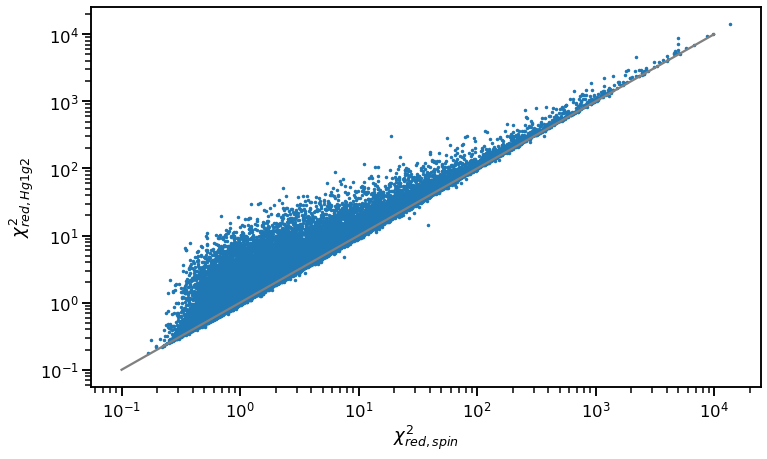

In [49]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.scatter( d1['chi2red'] , d1['chi2red_hg1g2'], s=4)
xx = np.logspace(-1,4)
ax.plot(xx,xx, color='grey')

ax.set_xlabel('$\chi^2_{red, spin}$')
ax.set_ylabel('$\chi^2_{red, Hg1g2}$')
ax.set_xscale('log')
ax.set_yscale('log')

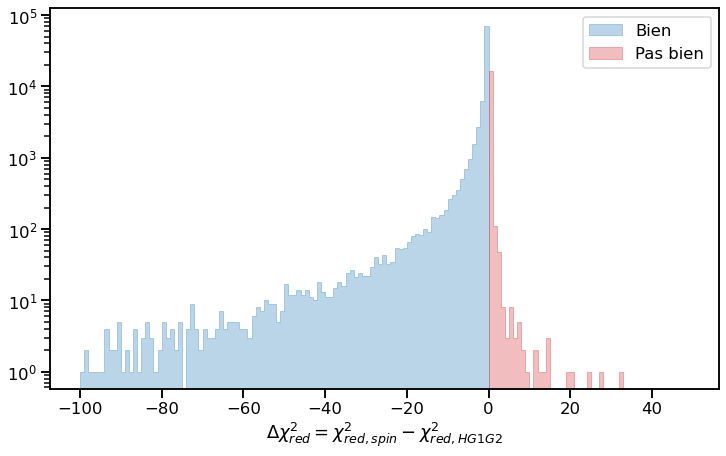

In [50]:
fig = plt.figure(figsize=(12, 7))

diff = d1['chi2red'] - d1['chi2red_hg1g2']
m = diff >= 0

bins = range(-100, 50, 1)
plt.hist((diff)[~m], bins=bins, range=[-100, 50], color='C0', alpha=0.3, lw=1, edgecolor='C0', histtype='stepfilled', label='Bien');
_, bins, _ = plt.hist((diff)[m], bins=bins, range=[-100, 50], color='C3', alpha=0.3, lw=1, edgecolor='C3', histtype='stepfilled', label='Pas bien');

plt.yscale('log')
plt.xlabel('$\Delta \chi^2_{red} = \chi^2_{red, spin} - \chi^2_{red, HG1G2}$')
plt.legend()
fig.savefig(f'{data_fink}plots/dchi2.png', facecolor='white', dpi=150)
plt.show()

## Families

Text(0, 0.5, 'Absolute magnitude H')

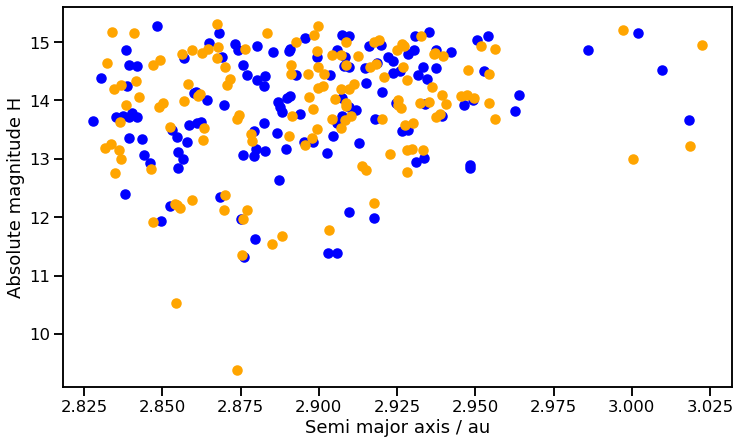

In [56]:
fig, ax = plt.subplots(figsize=(12, 7))


fam = 'Koronis'
flavor = 'silver'
prog = (data['family.family_name']==fam) & \
       (data['obliquity_alt']<90) & \
       (data['flavor']==flavor)
xax = 'proper_elements.proper_semi_major_axis.value'
yax = 'proper_elements.proper_inclination.value'
yax = 'absolute_magnitude.value'

ax.scatter( data.loc[prog,xax], 
            data.loc[prog,yax], 
            color='blue' )

retro = (data['family.family_name']==fam) & \
        (data['obliquity_alt']>=90) & \
       (data['flavor']==flavor)
ax.scatter( data.loc[retro,xax], 
            data.loc[retro,yax], 
            color='orange' )

ax.set_xlabel('Semi major axis / au')
ax.set_ylabel('Absolute magnitude H')


We have a complete **patchwork** of obliquity (prograde/retrograde-wise) in the family, while we expect a clear separation (at mid-semi major axis)

## Spin orientation on the celestial sphere

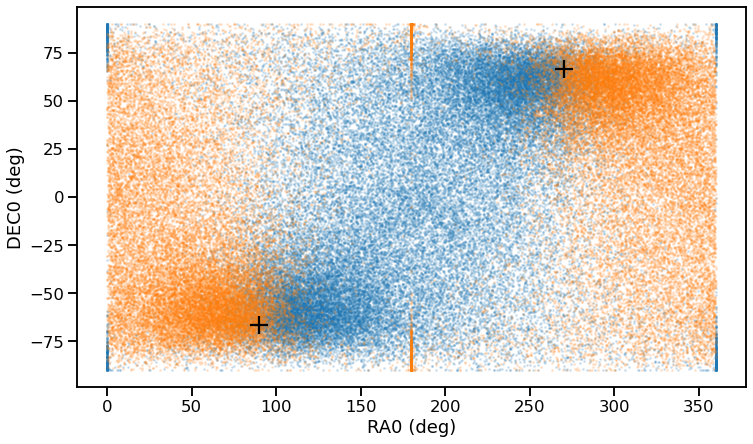

In [57]:
fig, ax = plt.subplots(figsize=(12, 7))

flavor = 'silver'
cond = (data['flavor']==flavor)
cond = (data.index %2 ==0 )
xax = 'RA0'
yax = 'DEC0'

ax.scatter( data.loc[cond,xax], 
            data.loc[cond,yax], 
          s=2, alpha=0.15)
ax.scatter( (data.loc[~cond,xax]-180) % 360, 
            -data.loc[~cond,yax], 
          s=2, alpha=0.15)

# coords = SkyCoord(ra=ra, dec=dec, distance=200*u.parsec, frame='hcrs')
# data['lon'] = coords.heliocentricmeanecliptic.lon.value
# data['lat'] = coords.heliocentricmeanecliptic.lat.value
coords = SkyCoord(lon=0.1*u.degree, lat=89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )
coords = SkyCoord(lon=0.1*u.degree, lat=-89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )


ax.set_xlabel('RA0 (deg)')
ax.set_ylabel('DEC0 (deg)')
fig.savefig(f'{data_fink}plots/ra0_vs_dec0_with_flip.png', facecolor='white', dpi=150)



If we remove the 1/2 randomized spin orientation, the figure is super scary. But otherwise, the distribution close to EC poles is VERY nice

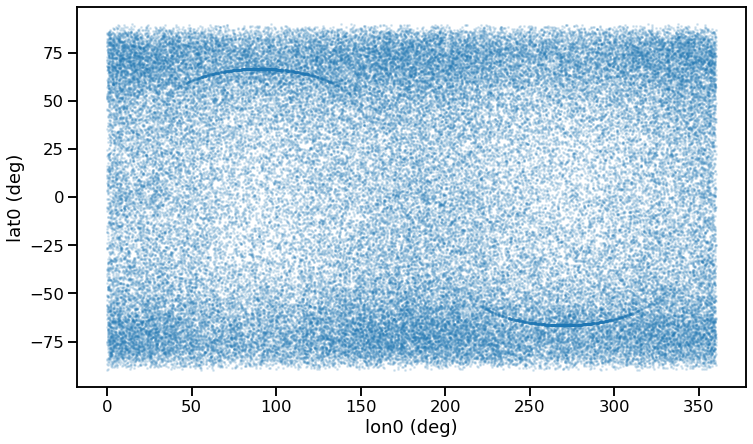

In [58]:
fig, ax = plt.subplots(figsize=(12, 7))


# Against simple/stupid randomization of orientation
cond = (data.index %2 == 0 )
data['lon_flip'] = data['lon']
data.loc[cond,'lon_flip'] = (data.loc[cond,'lon']-180) % 360
data['lat_flip'] = data['lat']
data.loc[cond,'lat_flip'] = -data.loc[cond,'lat']


flavor = 'silver'
cond = (data['flavor']==flavor)
cond = (data['flavor']==data['flavor'])
xax = 'lon_flip'
yax = 'lat_flip'



ax.scatter( data.loc[cond,xax], 
            data.loc[cond,yax], 
          s=2, alpha=0.15)
ax.set_xlabel('lon0 (deg)')
ax.set_ylabel('lat0 (deg)')
fig.savefig(f'{data_fink}plots/lon0_vs_lat0.png', facecolor='white', dpi=150)



VERY nice concentration at EC poles, homogeneous at low lat

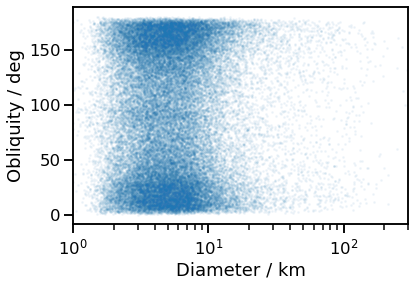

In [60]:
fig, ax = plt.subplots()


flavor = 'silver'
cond = (data['flavor']==flavor)
cond = (data['flavor']==data['flavor'])

ax.scatter( data.loc[cond,'diameter.value'],
            data.loc[cond,'obliquity'], 
            s=2, alpha=0.05 )

ax.set_xscale('log')
ax.set_xlim(1,300)
ax.set_xlabel('Diameter / km')
ax.set_ylabel('Obliquity / deg')

fig.savefig(f'{data_fink}plots/obliquity_vs_diameter.png', facecolor='white', dpi=150)


A very clear signal of YORP at small diameters!!